# Сессионное задание: Диффузионные модели

**План задания** (суммарно **50 баллов**)

1. **2D-датасет SwissRoll** (суммарно **40 баллов**)
    1. Реализовать прямой и обратный процессы диффузии и обучить базовый DDPM. (20 баллов)
    2. Реализовать classifier-free guidance. (10 баллов)
    3. Реализовать ускоренный семплинг. (10 баллов)

2. **Датасет MNIST** (суммарно **10 баллов**)
    1. Визуализировать прямой диффузионный процесс. (1 балл)
    2. Обучить диффузионную модель с визуально хорошим качеством генерации. (7 баллов)
    3. Сравнить генерации с помощью classifier-free guidance для разных значений guidance scale. (2 балла)

Ваша задача — заполнить пропуски внутри блоков с подписью `ваш код`.

Если вы работаете в `Google Colab`, нужно, чтобы Python «видел» дополнительный файл `utils.py`, который приложен к заданию:

1. Загрузите файл `utils.py` на ваш Google Drive.
2. Раскомментируйте код ниже.
3. Укажите в переменной `path` путь к файлу `utils.py` на вашем Google Drive.

***Примечание***: работа выполнялась в Kaggle, поэтому внесены соответствующие правки в пути загрузки

In [2]:
path = "/kaggle/input/utils-py/utils.py"
!cp $path .

In [4]:
import os
import re
import random

import numpy as np
import seaborn as sns
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle
from tqdm import tqdm
from copy import deepcopy
from typing import Optional, Tuple, List

from utils import get_labeled_data_loader, MyUNet

## DDPM

В этой части мы реализуем свою собственную модель (DDPM) и применим её на датасете SwissRoll.

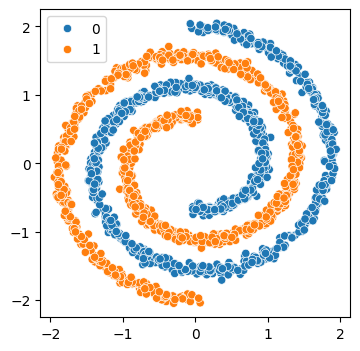

In [5]:
def make_swiss_dataset(num_samples):
    X0, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X1, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X0 = X0[:, [0, 2]]
    X1 = X1[:, [0, 2]]
    X1 = -X1
    X, y = shuffle(
        np.concatenate([X0, X1], axis=0),
        np.concatenate([np.zeros(len(X0)), np.ones(len(X1))], axis=0),
        random_state=0)
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    return X, y

X, y = make_swiss_dataset(2000)
y = y.astype(int)

plt.figure(figsize=(4, 4))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

**Кратко повторим теорию диффузионных моделей.**

Диффузионная модель состоит из прямого и обратного процессов.

Прямой процесс задаётся условным распределением $q(x_{1:T} \mid x_0)$.

Это марковская цепь, которая последовательно добавляет гауссовский шум к исходному объекту $x_0$.

На каждом шаге добавляется шум некоторой величины, которая определяется расписанием дисперсий $\{\beta_1, \ldots, \beta_T\}$.

Если это расписание выбрано правильно и $T$ стремится к бесконечности (или достаточно велико), процесс сходится к стандартному гауссовскому распределению $\mathcal{N}(0, I)$.

Распределения $q$ имеют следующий вид:
$$
 q(x_t \mid x_{t - 1}) := \mathcal{N}(x_t; \sqrt{1 - \beta_t}\,x_{t - 1}, \beta_t I),
 \qquad
 q(x_{1:T}\mid x_0) = \prod_{t = 1}^T q(x_t \mid x_{t - 1}).
$$

Теперь рассмотрим обратный процесс.

Обратный процесс последовательно удаляет шум, начиная с чистого гауссовского шума, до тех пор, пока не будет получен объект из исходного распределения.

Таким образом, диффузионная модель является вероятностной моделью с латентными переменными
$p_\theta(x_0) := \int p_\theta(x_{0:T}) \, dx_{1:T}$,
где латентные переменные $x_1, \ldots, x_T$ соответствуют зашумлённым объектам, а $x_0$ — объекту из исходного распределения.

Совместное распределение $p_\theta(x_{0:T})$ определяет обратный процесс диффузии и по сути представляет собой марковскую цепь гауссовых распределений $p_\theta(x_{t-1}\mid x_t)$:

$$
p_\theta(x_{0:T}) = p_\theta(x_T)\,\prod_{t = 1}^T p_\theta(x_{t-1}\mid x_t),
\qquad
p_\theta(x_T) = \mathcal{N}(x_T \mid 0, I),
$$
$$
p_{\theta}(x_{t - 1}\mid x_t) := \mathcal{N}(x_{t - 1}; \mu_{\theta}(x_t, t), \Sigma_{\theta}(x_t, t)).
$$

Вернёмся к распределению $q(x_t \mid x_{t - 1})$.

Чтобы получить $x_t$, нам нужно итеративно вычислить $x_1, \ldots, x_{t - 1}$.

Однако благодаря свойствам гауссовского распределения это можно сделать более эффективно.

Обозначим
$\alpha_t := 1 - \beta_t$ и $\bar{\alpha}_t := \prod_{i = 1}^t \alpha_i$.

Тогда
$$
q(x_t \mid x_0) = \mathcal{N}\bigl(x_t;\sqrt{\bar{\alpha}_t}\,x_0, (1-\bar{\alpha}_t)I\bigr). \qquad (1)
$$

В результате модель может быть обучена путём оптимизации отдельных членов суммы вариационной нижней границы:
$$
L_{VLB} = \mathbb{E}_q \Big[
\underbrace{D_\text{KL}(q(\mathbf{x}_T \mid \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_T))}_{L_T}
+ \sum_{t=2}^T
\underbrace{D_\text{KL}(q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) \parallel p_\theta(\mathbf{x}_{t-1} \mid \mathbf{x}_t))}_{L_{t-1}}
\underbrace{- \log p_\theta(\mathbf{x}_0 \mid \mathbf{x}_1)}_{L_0}
\Big].
$$

Для обучения необходимо выписать следующее распределение
$q(\mathbf{x}_{t-1} \mid \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I})$:

$$
\boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) =
\frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t}\,\mathbf{x}_t
+ \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t}\,\mathbf{x}_0
\qquad (2)
$$
$$
\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t. \qquad (3)
$$

Подробности можно найти в работе [Denoising Diffusion Probabilistic Models (Ho et al., 2020)](https://arxiv.org/abs/2006.11239).

В этой статье было показано, что при обучении с более простой функцией потерь достигаются лучшие результаты.

Вспомним, что
$$
x_t(x_0, \epsilon) = \sqrt{\bar{\alpha}_t}\,x_0 + \sqrt{1-\bar{\alpha}_t}\,\epsilon,
\qquad
\epsilon \sim \mathcal{N}(0, I). \qquad (4)
$$

Пусть наша модель предсказывает $\epsilon$ из приведённого выше выражения, обучаясь путём оптимизации следующей функции потерь:
$$
L^{\text{simple}}_t = \mathbb{E}_{x_0, \epsilon, t}\big[ \|\epsilon - \epsilon_{\theta}(x_t, t)\|^2 \big].
$$

В этом задании будет использоваться именно эта функция потерь.

Для выполнения семплинга (обратного процесса) нам необходимо получить $\mu_{\theta}(x_t, x_0)$ из $\epsilon_{\theta}(x_t, t)$.

Для этого найдите $\hat{x}_0(\epsilon_{\theta}, x_t)$ из уравнения (4) и подставьте его в уравнение (2).

_____

In [6]:
# Это вспомогательная функция, которая понадобится вам в этом задании.
# Например, когда вы захотите по батчу временных меток брать из предвычисленного массива
# соответствующие коэффициенты прямого диффузионного процесса.

def _extract_into_tensor(arr: th.Tensor, timesteps: th.Tensor, broadcast_shape: Tuple):
    """
    Вытаскивает значения из одномерного тензора по батчу индексов.

    Параметры:
    - arr: одномерный тензор.
    - timesteps: батч индексов, по которым хотим извлечь значения из тензора.
    - broadcast_shape: shape с K размерностями, к которому нужно привести итоговый тензор.

    Возвращает: тензор с shape [batch_size, 1, ...], где shape имеет K размерностей.
    """
    res = arr.to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)

In [7]:
# Функция, которая возвращает список «рабочих» коэффициентов betas для диффузионного процесса
# в зависимости от длины марковской цепочки.

def get_beta_schedule(num_diffusion_timesteps: int) -> th.Tensor:
    scale = 1000 / num_diffusion_timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
    betas = th.from_numpy(betas).double()
    return betas

In [8]:
# Класс BaseDiffusion принимает на вход коэффициенты betas, которые задают и прямой, и обратный процессы.
# Также в этом классе мы предварительно вычисляем величины, которые пригодятся нам позднее.

class BaseDiffusion:
    def __init__(self, betas: th.Tensor) -> None:
        self.betas = betas
        self.alphas = 1 - self.betas
        self.alphas_cumprod = th.cumprod(self.alphas, dim=-1)
        self.num_timesteps = len(self.betas)

basediff = BaseDiffusion(get_beta_schedule(20))
basediff.alphas_cumprod

tensor([9.9500e-01, 9.3792e-01, 8.3499e-01, 6.9964e-01, 5.4958e-01, 4.0293e-01,
        2.7431e-01, 1.7238e-01, 9.9302e-02, 5.2003e-02, 2.4510e-02, 1.0268e-02,
        3.7641e-03, 1.1827e-03, 3.0969e-04, 6.4872e-05, 1.0192e-05, 1.0674e-06,
        5.5900e-08, 0.0000e+00], dtype=torch.float64)

### Реализуйте прямой процесс диффузии

In [9]:
class ForwardDiffusion(BaseDiffusion):
    def q_mean_variance(self, x0: th.Tensor, t: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
        # ====
        # ваш код
        # посчитайте среднее и дисперсию q(x_t | x_0) (используйте выражение (1))
        mean = _extract_into_tensor(self.alphas_cumprod.sqrt(), t, x0.shape) * x0
        variance = 1.0 - _extract_into_tensor(self.alphas_cumprod, t, x0.shape)
        # ====
        return mean, variance

    def q_sample(self, x0: th.Tensor, t: th.Tensor, noise: Optional[th.Tensor]=None) -> th.Tensor:
        if noise is None:
            noise = th.randn_like(x0)
        # ====
        # ваш код
        # просемплируйте из q(x_t | x_0) (используйте выражение (1))
        mean, variance = self.q_mean_variance(x0, t)
        samples = mean + th.sqrt(variance) * noise
        # ====
        return samples

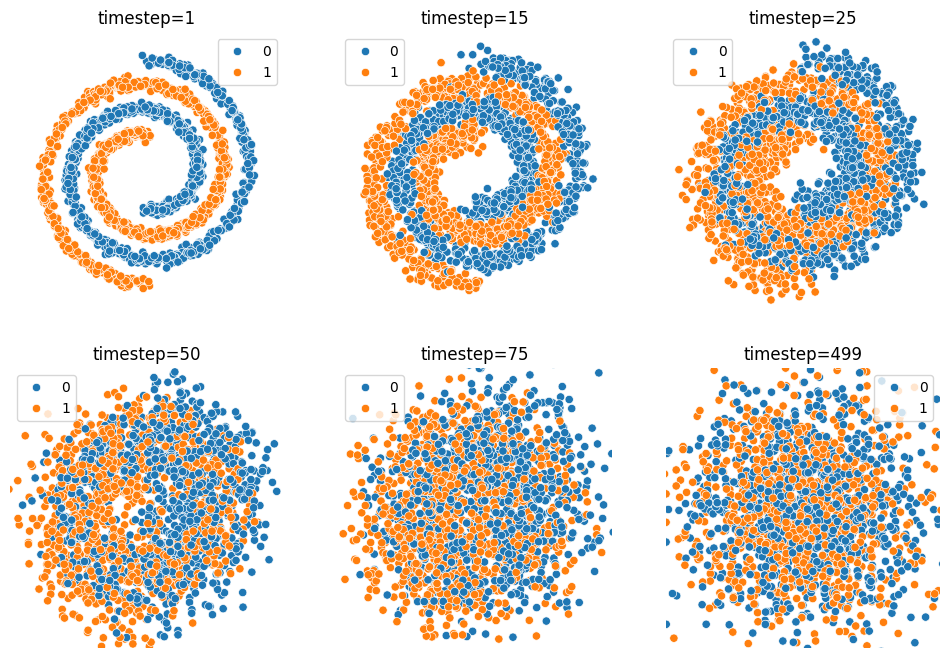

In [10]:
# Посмотрим на прямой процесс диффузии, применённый к SwissRoll

T = 500
forward_diffusion = ForwardDiffusion(get_beta_schedule(T))

timesteps_to_plot = [1, 15, 25, 50, 75, 499]
n_plots = len(timesteps_to_plot)
ncols = 3
nrows = n_plots // ncols

_, axes = plt.subplots(nrows=nrows, ncols=ncols,  figsize=(4 * ncols, 4 * nrows), squeeze=False)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j

        X_noised = forward_diffusion.q_sample(
            x0=th.from_numpy(X),
            t=th.ones_like(th.from_numpy(y)).long() * timesteps_to_plot[idx],
        )
        sns.scatterplot(x=X_noised[:, 0], y=X_noised[:, 1], hue=y, ax=axes[i, j])
        axes[i, j].set_title(f"timestep={timesteps_to_plot[idx]}")
        axes[i, j].set_xlim(-2.5, 2.5); axes[i, j].set_ylim(-2.5, 2.5)
        axes[i, j].set_axis_off()

### Реализуйте обратный процесс диффузии

In [11]:
class ReverseDiffusion(BaseDiffusion):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.alphas_cumprod_prev = th.cat(
            [th.tensor([1.0], device=self.betas.device), self.alphas_cumprod[:-1]], dim=0
        )
        # ====
        # ваш код
        # посчитайте дисперсию распределения q(x_{t-1} | x_t, x_0) (используйте выражение (3))
        self.variance = (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod) * self.betas
        # ====

        # ====
        # ваш код
        # посчитайте коэффициенты среднего значения q(x_{t-1} | x_t, x_0) (используйте выражение (2))
        self.xt_coef = (self.alphas.sqrt() * (1 - self.alphas_cumprod_prev)) / (1 - self.alphas_cumprod)
        self.x0_coef = (self.alphas_cumprod_prev.sqrt() * self.betas) / (1 - self.alphas_cumprod)
        # ====

    def get_x0(self, xt: th.Tensor, eps: th.Tensor, t: th.Tensor) -> th.Tensor:
        # ====
        # ваш код
        # посчитайте x0 (используйте выражения (4) и (2))
        alphas_cumprod_t = _extract_into_tensor(self.alphas_cumprod, t, xt.shape)
        x0 = (xt - th.sqrt(1 - alphas_cumprod_t) * eps) / th.sqrt(alphas_cumprod_t)
        # ====
        return x0

    def q_posterior_mean_variance(
        self, xt: th.Tensor, eps: th.Tensor, t: th.Tensor
    ) -> Tuple[th.Tensor, th.Tensor]:
        # ====
        # ваш код
        # посчитайте среднее и дисперсию распределения q(x_{t-1} | x_t, x_0) (используйте выражения (2) и (3))
        x0 = self.get_x0(xt, eps, t)
        
        xt_coef = _extract_into_tensor(self.xt_coef, t, xt.shape)
        x0_coef = _extract_into_tensor(self.x0_coef, t, x0.shape)
        
        mean = xt_coef * xt + x0_coef * x0
        
        variance = _extract_into_tensor(self.variance, t, xt.shape)
        # ====
        return mean, variance

    def p_sample(self, xt: th.Tensor, eps: th.Tensor, t: th.Tensor) -> th.Tensor:
        # прочитайте код для одного шага генерации внимательно
        mean, variance = self.q_posterior_mean_variance(xt=xt, eps=eps, t=t)
        noise = th.randn_like(xt, device=xt.device)

        nonzero_mask = th.ones_like(t) # чтобы не добавлять шум, если t = 0
        nonzero_mask[t == 0] = 0
        nonzero_mask = _extract_into_tensor(
            nonzero_mask, th.arange(nonzero_mask.shape[0]), xt.shape
        )
        nonzero_mask = nonzero_mask.to(xt.device)

        sample = mean + nonzero_mask * variance.sqrt() * noise
        return sample.float()

### Реализуем архитектуру нейронной сети для предсказания шума

In [12]:
# Заметьте, что модель на вход принимает не только зашумлённый объект,
# но также момент времени и индекс класса.

class ConditionalMLP(nn.Module):
    def __init__(self, d_in: int, T: int, n_classes: int, hidden_dim: Optional[int]=128):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.x_proj = nn.Linear(d_in, self.hidden_dim)
        self.t_proj = nn.Embedding(T, self.hidden_dim)
        self.y_embed = nn.Embedding(n_classes, self.hidden_dim)
        self.backbone = nn.Sequential(
            nn.Linear(self.hidden_dim, 2 * self.hidden_dim),
            nn.GELU(),
            nn.Linear(2 * self.hidden_dim, d_in)
        )

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x, t, y):
        """
        Параметры:
        - x: зашумлённая картинка.
        - t: счётчик времени/уровень шума.
        - y: индекс класса, который нужно сгенерировать.
        """
        x = self.x_proj(x)
        t = self.t_proj(t.int())
        y = self.y_embed(y)
        x = x + t + y
        x = F.gelu(x)
        return self.backbone(x)

### Реализуйте DDPM

In [13]:
class DDPM(nn.Module):
    def __init__(
        self,
        betas: th.Tensor,
        model: nn.Module,
        shape: Optional[th.Tensor] = None,
    ) -> None:
        super().__init__()

        self.forward_diffusion = ForwardDiffusion(betas=betas)
        self.reverse_diffusion = ReverseDiffusion(betas=betas)
        self.model = model
        self.num_timesteps = len(betas)

        self.register_buffer("betas", betas)
        self.register_buffer("shape", shape)

    @property
    def device(self) -> None:
        return next(self.parameters()).device

    @th.no_grad()
    def sample(self, y: th.Tensor) -> th.Tensor:
        num_samples = y.shape[0]
        x = th.randn((num_samples, *self.shape), device=self.device, dtype=th.float32)
        indices = list(range(self.num_timesteps))[::-1]

        for i in tqdm(indices):
            t = th.tensor([i] * num_samples, device=x.device)
            # ====
            # ваш код
            # 1) предскажите шум с помощью модели
            # 2) сделайте шаг разшумления
            eps = self.model(x, t, y)
            x = self.reverse_diffusion.p_sample(x, eps, t)
            # ====
        return x, y

    def train_loss(self, x0: th.Tensor, y: th.Tensor) -> th.Tensor:
        if self.shape is None:
            self.shape = th.tensor(list(x0.shape)[1:], device="cpu")
        t = th.randint(0, self.num_timesteps, size=(x0.size(0),), device=x0.device)
        noise = th.randn_like(x0)
        # ====
        # ваш код
        # 1) зашумите x0 и получите xt
        # 2) предскажите по xt наложенный на него шум
        xt = self.forward_diffusion.q_sample(x0, t, noise)
        eps = self.model(xt, t, y)
        # ====
        loss = F.mse_loss(eps, noise)
        return loss

In [14]:
# Теперь давайте обучим наш DDPM.

def train_model(
    ddpm: DDPM,
    dataloader: DataLoader,
    *,
    lr: float,
    n_iters: int,
    device: str = "cpu",
    log_every: int = 500
):
    ddpm.to(device)

    optimizer = th.optim.Adam(ddpm.model.parameters(), lr=lr)

    step = 0
    curr_loss_gauss = 0.0
    curr_count = 0
    optimizer.zero_grad()
    data_iter = iter(dataloader)
    while step < n_iters:
        try:
            batch = next(data_iter)
        except StopIteration:
            data_iter = iter(dataloader)
            batch = next(data_iter)

        x, y = batch["x"].to(device), batch["y"].to(device)

        loss = ddpm.train_loss(x, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        curr_count += len(x)
        curr_loss_gauss += loss.item() * len(x)

        if (step + 1) % log_every == 0:
            gloss = np.around(curr_loss_gauss / curr_count, 4)
            print(f"Step {(step + 1)}/{n_iters} Loss: {gloss}")
            curr_count = 0
            curr_loss_gauss = 0.0

        step += 1

In [15]:
T = 500
BATCH_SIZE = 1024
LR = 0.01
N_ITERS = 10000

model = ConditionalMLP(d_in=2, T=T, n_classes=2)
device = "cuda" # можно считать на гпу, но цпу должно быть достаточно

ddpm = DDPM(betas=get_beta_schedule(T), model=model)
dataloader = get_labeled_data_loader(X, y, batch_size=BATCH_SIZE, shuffle=True)

train_model(
    ddpm=ddpm,
    dataloader=dataloader,
    lr=LR,
    n_iters=N_ITERS,
    device=device
)

Step 500/10000 Loss: 0.2851
Step 1000/10000 Loss: 0.2615
Step 1500/10000 Loss: 0.2593
Step 2000/10000 Loss: 0.2553
Step 2500/10000 Loss: 0.2487
Step 3000/10000 Loss: 0.2462
Step 3500/10000 Loss: 0.2432
Step 4000/10000 Loss: 0.2423
Step 4500/10000 Loss: 0.2418
Step 5000/10000 Loss: 0.2404
Step 5500/10000 Loss: 0.2384
Step 6000/10000 Loss: 0.2398
Step 6500/10000 Loss: 0.2396
Step 7000/10000 Loss: 0.237
Step 7500/10000 Loss: 0.2381
Step 8000/10000 Loss: 0.2374
Step 8500/10000 Loss: 0.2359
Step 9000/10000 Loss: 0.2381
Step 9500/10000 Loss: 0.2372
Step 10000/10000 Loss: 0.2366


100%|██████████| 500/500 [00:00<00:00, 544.01it/s]


Text(0.5, 1.0, 'real')

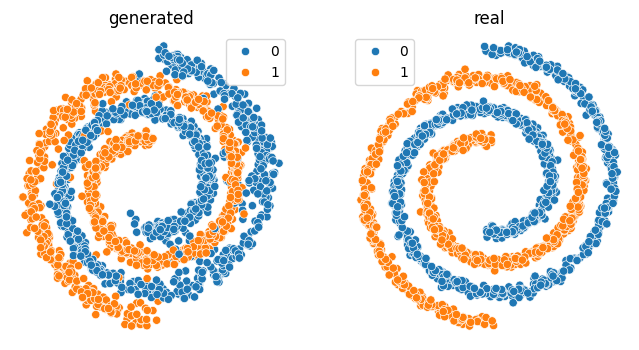

In [16]:
# Теперь давайте посмотрим, что наша модель научилась генерировать (должно быть похоже на наш SwissRoll датасет)

num_samples = X.shape[0]
ys = th.randint(0, 2, size=(num_samples,), device=device)
Xs, ys = ddpm.sample(ys)

_, (ax_gen, ax_real) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
sns.scatterplot(x=Xs[:, 0].cpu().numpy(), y=Xs[:, 1].cpu().numpy(), hue=ys.cpu().numpy(), ax=ax_gen); ax_gen.set_axis_off();
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax_real); ax_real.set_axis_off();

ax_gen.set_title("generated")
ax_real.set_title("real")

## Classifier-free guidance

К этому моменту мы реализовали базовый алгоритм для диффузионных моделей DDPM.

Теперь реализуем **classifier-free guidance** — технику для улучшения class-conditional генерации, которую мы разбирали на лекции.

Итоговая формула очень простая:
$$
\hat{\epsilon}_\theta(x_t, t, y) =
\epsilon_\theta(x_t, t, y=\varnothing)
+ s\bigl(\epsilon_\theta(x_t, t, y) - \epsilon_\theta(x_t, t, y=\varnothing)\bigr), \qquad (1)
$$
где:
- $\epsilon_\theta(x_t, t, y)$ — модель, которую мы обучаем;
- $s$ — guidance scale (контролирует силу guidance);
- $\hat{\epsilon}_\theta(x_t, t, y)$ — итоговая модель для предсказания шума;
- $y$ — класс, который мы хотим сгенерировать;
- $y = \varnothing$ означает, что в нейронную сеть подаётся специальный «пустой» класс для unconditional-режима.

**Обучение** происходит следующим образом:

1. Семплируем
   $$
   (x_0, c) \sim p_{\text{data}}, \quad
   t \sim \text{Uniform}\{1, \ldots, T\}, \quad
   \epsilon \sim \mathcal{N}(0, I).
   $$
2. Зашумляем данные:
   $$
   x_t = \sqrt{\bar{\alpha}_t}\,x_0 + \sqrt{1 - \bar{\alpha}_t}\,\epsilon.
   $$
3. С вероятностью $p$ выбираем, учим ли мы модель в unconditional- или conditional-режиме:
   - unconditional:
     $$
     \|\epsilon_\theta(x_t, t, y=\varnothing) - \epsilon\|_2^2,
     $$
   - conditional:
     $$
     \|\epsilon_\theta(x_t, t, y=c) - \epsilon\|_2^2.
     $$

*Замечание.* Логика выбора unconditional-/conditional-режима обучения реализована за вас в классе `LabeledDataset` (лежит в `utils.py`). Это сделано затем, чтобы можно было переиспользовать функцию `train_model` без изменений. Обратите внимание на параметр `drop_label`.


### Реализуйте Classifier-free Guidance

In [17]:
class DDPMWithCFG(DDPM):
    @th.no_grad()
    def sample_with_cfg(self, y: th.Tensor, guidance_scale: float=0., null_label: int=2):
        """
        Параметры:
        - y: метка класса;
        - guidance_scale:
            - 0: unconditional-режим;
            - 1: conditional-режим, честно восстанавливающий распределение;
            - чем выше значение, тем сильнее влияние класса;
        - null_label: заранее подготовленный индекс класса, отвечающий за unconditional-обучение.
        """
        assert self.shape is not None
        num_samples = y.shape[0]
        x = th.randn((num_samples, *self.shape), device=self.device, dtype=th.float32)
        indices = list(range(self.num_timesteps))[::-1]

        for i in tqdm(indices):
            t = th.tensor([i] * num_samples, device=x.device)
            # ====
            # ваш код
            # 1) предскажите epsilon с крышечкой с помощью метод `_predict_eps_hat`
            # 2) сделайте шаг разшумления
            eps_hat = self._predict_eps_hat(x, t, y, guidance_scale, null_label)
            x = self.reverse_diffusion.p_sample(x, eps_hat, t)
            # ====
        return x, y

    def _predict_eps_hat(self, x: th.Tensor, t: th.Tensor, y: th.Tensor, guidance_scale: float, null_label: int):
        null_y = null_label * th.ones_like(y)
        # ====
        # ваш код
        # предскажите epsilon с крышечкой с помощью модели (используйте выражение (1))
        eps_uncond = self.model(x, t, null_y)
        eps_cond = self.model(x, t, y)
        eps_hat = eps_uncond + guidance_scale * (eps_cond - eps_uncond)
        # ====
        return eps_hat

In [18]:
T = 500
BATCH_SIZE = 1024
LR = 0.01
N_ITERS = 30000
DROP_LABEL = 0.4

model = ConditionalMLP(d_in=2, T=T, n_classes=2+1)
device = "cpu" # можно считать на гпу, но цпу должно быть достаточно

ddpm = DDPMWithCFG(betas=get_beta_schedule(T), model=model)
dataloader = get_labeled_data_loader(X, y, batch_size=BATCH_SIZE, shuffle=True, drop_label=DROP_LABEL)

train_model(
    ddpm=ddpm,
    dataloader=dataloader,
    lr=LR,
    n_iters=N_ITERS,
    device=device
)

Step 500/30000 Loss: 0.2886
Step 1000/30000 Loss: 0.2666
Step 1500/30000 Loss: 0.2652
Step 2000/30000 Loss: 0.2634
Step 2500/30000 Loss: 0.2634
Step 3000/30000 Loss: 0.2604
Step 3500/30000 Loss: 0.2579
Step 4000/30000 Loss: 0.2574
Step 4500/30000 Loss: 0.2566
Step 5000/30000 Loss: 0.2561
Step 5500/30000 Loss: 0.2525
Step 6000/30000 Loss: 0.2522
Step 6500/30000 Loss: 0.2515
Step 7000/30000 Loss: 0.249
Step 7500/30000 Loss: 0.2486
Step 8000/30000 Loss: 0.2491
Step 8500/30000 Loss: 0.2494
Step 9000/30000 Loss: 0.2478
Step 9500/30000 Loss: 0.247
Step 10000/30000 Loss: 0.2485
Step 10500/30000 Loss: 0.2479
Step 11000/30000 Loss: 0.2472
Step 11500/30000 Loss: 0.2468
Step 12000/30000 Loss: 0.2477
Step 12500/30000 Loss: 0.2475
Step 13000/30000 Loss: 0.2463
Step 13500/30000 Loss: 0.2464
Step 14000/30000 Loss: 0.2465
Step 14500/30000 Loss: 0.2456
Step 15000/30000 Loss: 0.2459
Step 15500/30000 Loss: 0.2471
Step 16000/30000 Loss: 0.246
Step 16500/30000 Loss: 0.2439
Step 17000/30000 Loss: 0.2453
Ste

100%|██████████| 500/500 [00:02<00:00, 181.42it/s]


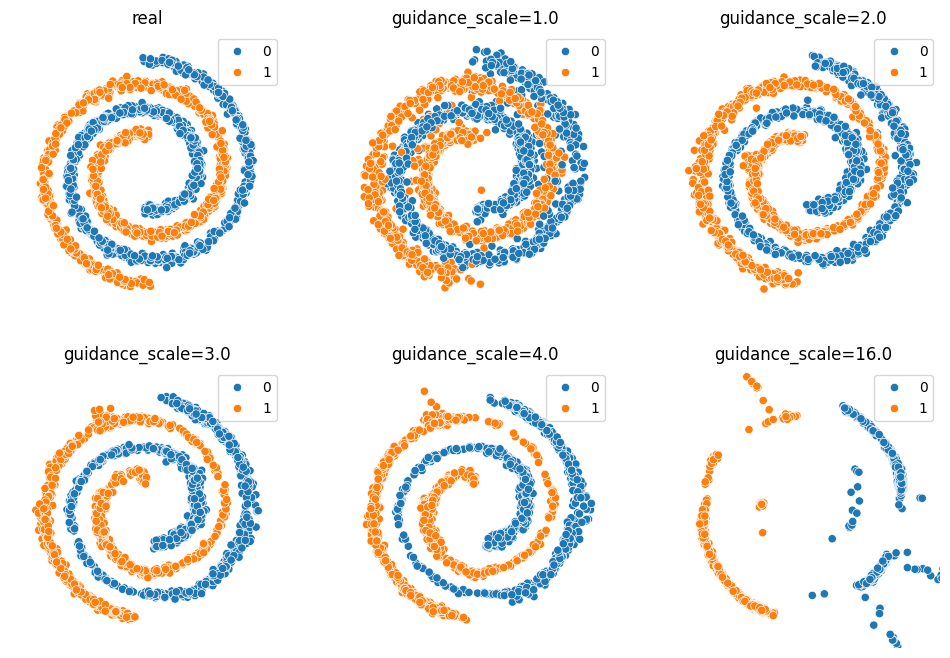

In [19]:
# Давайте посмотрим на качество генерации c разным guidance scale

guidance_scale_to_plot = [1.0, 2.0, 3.0, 4.0, 16.0]
n_plots = len(guidance_scale_to_plot) + 1
ncols = 3
nrows = n_plots // ncols

num_samples = X.shape[0]
ys = th.randint(0, 2, size=(num_samples,), device=device)

_, axes = plt.subplots(nrows=nrows, ncols=ncols,  figsize=(4 * ncols, 4 * nrows), squeeze=False)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j

        if idx == 0:
            sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=axes[i, j])
            axes[i, j].set_title("real")
        else:
            idx = idx - 1
            Xs, ys = ddpm.sample_with_cfg(ys, guidance_scale=guidance_scale_to_plot[idx], null_label=2)
            sns.scatterplot(x=Xs[:, 0].cpu().numpy(), y=Xs[:, 1].cpu().numpy(), hue=ys.cpu().numpy(), ax=axes[i, j])
            axes[i, j].set_title(f"guidance_scale={guidance_scale_to_plot[idx]}")
        axes[i, j].set_xlim(-2.5, 2.5); axes[i, j].set_ylim(-2.5, 2.5)
        axes[i, j].set_axis_off()

**Замечания про classifier-free guidance:**
- генерирует семплы, которые более вероятны для конкретного класса (чем выше guidance scale, тем меньше пересечения между генерациями разных классов);
- слишком большой guidance scale может приводить к выбросам

## Ускоренный семплинг из DDPM

На данном этапе мы реализовали DDPM и технику classifier-free guidance.
В текущей реализации для генерации нужно делать столько же шагов, сколько вершин в марковской цепочке, а в случае использования classifier-free guidance — в два раза больше.
Это не критично для нашего игрушечного датасета SwissRoll, однако чем сложнее датасет и больше размерность данных, тем дороже становится каждый шаг генерации.

В этой части мы реализуем математически обоснованный способ пропускать некоторые вершины марковской цепочки для более быстрого семплинга из DDPM. Этот подход мы также обсуждали на лекции.

Вкратце вспомним, что там происходило.

Пусть у нас есть DDPM с максимальным индексом вершины в марковской цепочке $T$, и мы хотим семплировать за $I < T$ шагов.
При этом важно, чтобы мы могли переиспользовать предобученную на $T$ шагах диффузионную модель $\epsilon_\theta(x_t, t)$, где $t \in \{1, \ldots, T\}$.

Для этого мы искали более короткую марковскую цепочку длины $I$ (вершины будут проиндексированы $i \in \{1, \ldots, I\}$), которая является подцепочкой исходной более длинной:

1. Мы выбрали, каким вершинам исходной длинной цепочки будет соответствовать новая цепочка. Для этого мы задали функцию
   $\tau: \{1, \ldots, I\} \to \{1, \ldots, T\}$,
   которая отображает временные индексы новой цепочки в индексы старой. При этом важно, чтобы $\tau(I) = T$, чтобы новая цепочка всё так же заканчивалась в стандартном гауссовском распределении.

2. Далее мы формализовали наше желание, чтобы новая короткая цепочка была подцепочкой исходной. Для этого мы выровняли их соответствующие маргинальные распределения:
   $$
   q_{\text{new}}(x_i) = q(x_{t = \tau(i)}).
   $$

3. Это условие позволило нам найти параметры короткой диффузионной марковской цепочки:
   $$
   \beta_{\text{new}, i} = 1 - \alpha_{\text{new}, i}
   = 1 - \frac{\bar{\alpha}_{\tau(i)}}{\bar{\alpha}_{\tau(i - 1)}}. \qquad (1)
   $$

4. Также это позволило нам переиспользовать предобученную на длинной цепочке диффузионную модель $\epsilon_\theta(x_t, t)$:
   $$
   \epsilon_{\text{new}, \theta}(x_i, i) = \epsilon_\theta(x_t = x_i, t = \tau(i)). \qquad (2)
   $$

Таким образом, нам нужно сделать класс DDPM с правильными параметрами новой, более короткой марковской цепочки, определёнными выше, и корректным переиспользованием предобученной диффузионной модели, чтобы семплировать за $I < T$ шагов.


### Реализуйте WrappedModel и SpacedDDPMWithCFG

In [20]:
class WrappedModel(nn.Module):
    """
    Класс обёртка для предобученной диффузионной модели epsilon(x_t, t),
        которая позволяет учитывать отображение tau счётчиков времени из нового в старый.

    Параметры:
    - model: предобученная диффузионная модель epsilon(x_t, t)
    - timestep_map: массив, который по индексу i содержит время tau(i)
    """
    def __init__(self, model: nn.Module, timestep_map: List):
        super().__init__()
        self.model = model
        self.timestep_map = timestep_map

    @property
    def device(self):
        return next(self.model.parameters()).device

    def forward(self, x: th.Tensor, t: th.Tensor, *args, **kwargs) -> th.Tensor:
        # ====
        # ваш код
        # посчитайте счётчик времени new_t старой (длинной) цепочки по счётчику времени t новой (короткой) цепочки
        # тут было бы нагляднее использовать i вместо t,
        #     но ранее в коде мы зафиксировали, что нейронная сеть принимает именованный аргумент t.
        new_t = th.tensor([self.timestep_map[i.item()] for i in t], device=t.device)
        # ====
        return self.model(x, new_t, *args, **kwargs)

In [21]:
class SpacedDDPMWithCFG(DDPMWithCFG):
    """
    Класс для адаптации DDPM для более короткой марковской цепочки.
    Переопределяет параметры betas и использование нейронной сети.

    Параметры:
    - kwargs: параметры, которые задают обычный DDPM (длинную цепочку);
    - use_timesteps: массив индексов длинной цепочки, по которым мы хотели бы ходить.
    """

    def __init__(self, use_timesteps: Optional[Tuple]=None, **kwargs):
        # Если use_timesteps не задан, будем ходить по всем вершинам длинной цепочки
        if use_timesteps is None:
            use_timesteps = list(range(len(kwargs["betas"])))
        self.use_timesteps = set(use_timesteps)

        base_ddpm = DDPM(**kwargs)

        last_alpha_cumprod = 1.0
        new_betas = []
        for t, alpha_cumprod in enumerate(base_ddpm.forward_diffusion.alphas_cumprod):
            if t in self.use_timesteps:
                # ====
                # ваш код
                # посчитайте параметры короткой марковской цепочки и положите их new_betas
                new_betas.append(1 - alpha_cumprod / last_alpha_cumprod)
                last_alpha_cumprod = alpha_cumprod
                # ====
        kwargs = deepcopy(kwargs)
        kwargs["betas"] = th.tensor(new_betas)
        kwargs["model"] = WrappedModel(kwargs["model"], use_timesteps)
        super().__init__(**kwargs)

In [22]:
# Вспомогательная функция, которая позволяет создать SpacedDDPMWithCFG по инстансу DDPM
# и задать количество шагов, которое мы хотим использовать.
# Эта функция распределяет шаги равномерно по вершинам (это частный случай и может быть неоптимален).

def get_spaced_ddpm(ddpm: DDPMWithCFG, num_timesteps: int=None):
    if num_timesteps is not None:
        num_timesteps = min(num_timesteps, ddpm.num_timesteps)
        use_timesteps = np.linspace(1, ddpm.num_timesteps, num=num_timesteps+1).astype("int")[1:]
    else:
        use_timesteps = None

    return SpacedDDPMWithCFG(
        use_timesteps=use_timesteps,
        betas=ddpm.betas,
        model=ddpm.model,
        shape=ddpm.shape,
    )

100%|██████████| 9/9 [00:00<00:00, 71.02it/s]


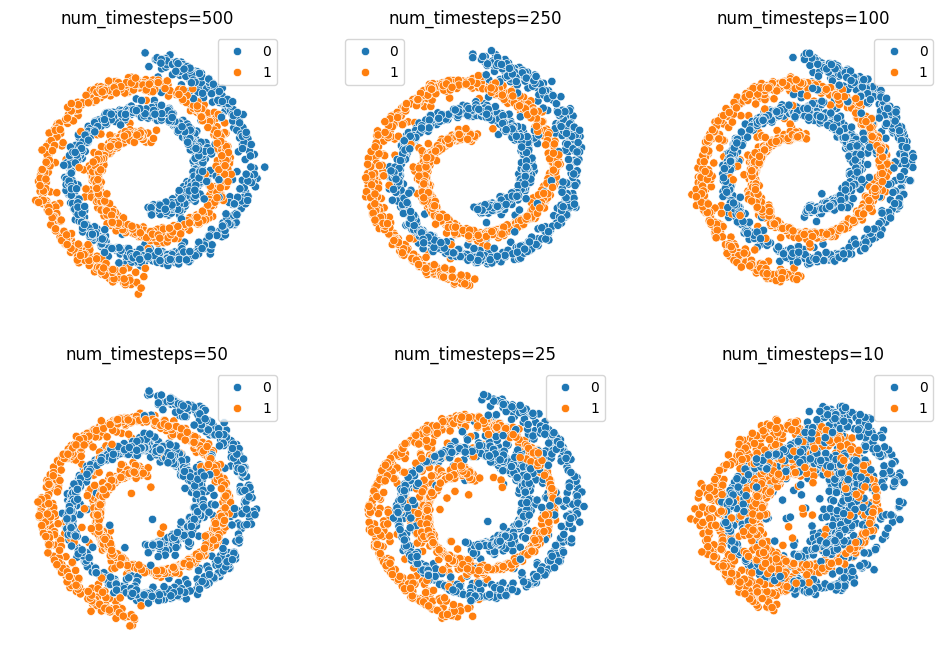

In [23]:
# Давайте посмотрим на качество генерации при уменьшении количества шагов семплирования (guidance_scale = 1).

guidance_scale = 1.

num_timesteps_to_plot = [500, 250, 100, 50, 25, 10]
n_plots = len(num_timesteps_to_plot)
ncols = 3
nrows = n_plots // ncols

num_samples = X.shape[0]
ys = th.randint(0, 2, size=(num_samples,), device=device)

_, axes = plt.subplots(nrows=nrows, ncols=ncols,  figsize=(4 * ncols, 4 * nrows), squeeze=False)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j

        spaced_ddpm = get_spaced_ddpm(ddpm, num_timesteps_to_plot[idx])
        Xs, ys = spaced_ddpm.sample_with_cfg(ys, guidance_scale=guidance_scale, null_label=2)
        sns.scatterplot(x=Xs[:, 0].detach().cpu().numpy(), y=Xs[:, 1].detach().cpu().numpy(), hue=ys.detach().cpu().numpy(), ax=axes[i, j])
        axes[i, j].set_title(f"num_timesteps={num_timesteps_to_plot[idx]}")
        axes[i, j].set_xlim(-2.5, 2.5); axes[i, j].set_ylim(-2.5, 2.5)
        axes[i, j].set_axis_off()

100%|██████████| 9/9 [00:00<00:00, 67.54it/s]


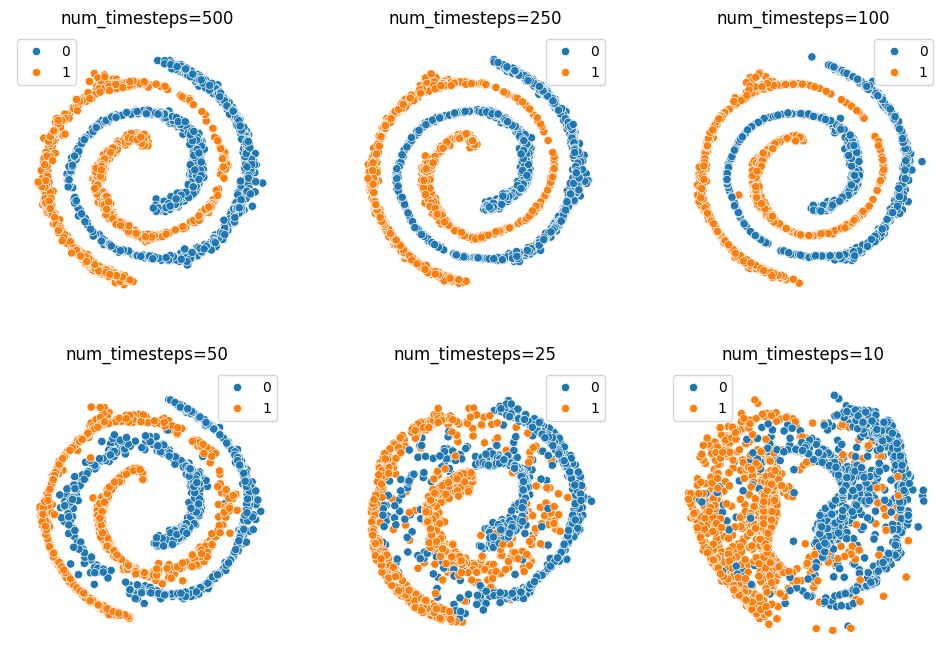

In [24]:
# Давайте посмотрим на качество генерации при уменьшении количества шагов семплирования (guidance_scale = 3).
guidance_scale = 3

num_timesteps_to_plot = [500, 250, 100, 50, 25, 10]
n_plots = len(num_timesteps_to_plot)
ncols = 3
nrows = n_plots // ncols

num_samples = X.shape[0]
ys = th.randint(0, 2, size=(num_samples,), device=device)

_, axes = plt.subplots(nrows=nrows, ncols=ncols,  figsize=(4 * ncols, 4 * nrows), squeeze=False)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j

        spaced_ddpm = get_spaced_ddpm(ddpm, num_timesteps_to_plot[idx])
        Xs, ys = spaced_ddpm.sample_with_cfg(ys, guidance_scale=guidance_scale, null_label=2)
        sns.scatterplot(x=Xs[:, 0].detach().cpu().numpy(), y=Xs[:, 1].detach().cpu().numpy(), hue=ys.detach().cpu().numpy(), ax=axes[i, j])
        axes[i, j].set_title(f"num_timesteps={num_timesteps_to_plot[idx]}")
        axes[i, j].set_xlim(-2.5, 2.5); axes[i, j].set_ylim(-2.5, 2.5)
        axes[i, j].set_axis_off()

Отлично! У нас получилось значительно сократить количество шагов генерации без особой потери в качестве!

## MNIST

В предыдущей части мы работали с двумерным датасетом SwissRoll.
Он может показаться слишком простым. Так и есть: именно из-за своей простоты он удобен для проверки и дебага нашего кода.

Теперь, когда мы видим, что наш код работает, протестируем его на чём-то посложнее — на MNIST!

In [25]:
# Скачаем датасет

from torchvision.datasets.mnist import MNIST

def mnist_to_train_range(X):
    return ((X.astype("float32") / 255.) - 0.5) * 2

def mnist_from_train_range(X):
    return (((X.astype("float32") + 1.0) / 2) * 255.).astype("int")

dataset = MNIST("./datasets", download=True, train=True)
X = dataset.data.numpy().astype("float32")[:, None]
y = dataset.targets.numpy()
mnist_loader = get_labeled_data_loader(mnist_to_train_range(X), y, batch_size=64)

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.05MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.76MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.97MB/s]


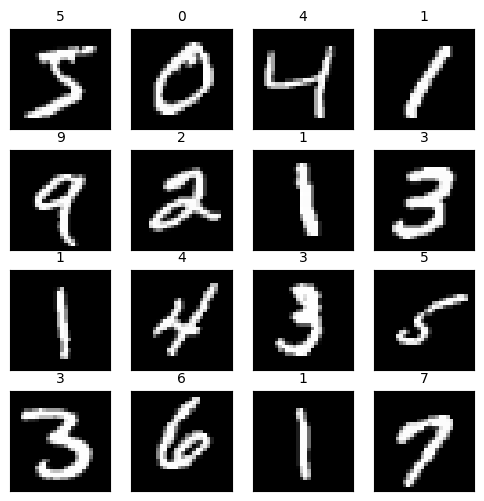

In [26]:
# Вспомогательная функция для визуализации

def show_images(images, ys, title=""):
    if type(images) is th.Tensor:
        images = images.detach().cpu().numpy()
        ys = ys.detach().cpu().numpy()

    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)
    fig = plt.figure(figsize=(cols*1.5, rows*1.5))

    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                plt.title(f"{int(ys[idx])}", fontsize=10)
                plt.tick_params(bottom = False, left=False, labelbottom=False, labelleft=False)
                idx += 1
    plt.show()

def show_first_batch(loader, batch_size=16):
    for batch in loader:
        show_images(batch["x"][:batch_size], batch["y"][:batch_size], "Images in the first batch")
        break

show_first_batch(mnist_loader)

### Визуализируйте прямой процесс диффузии

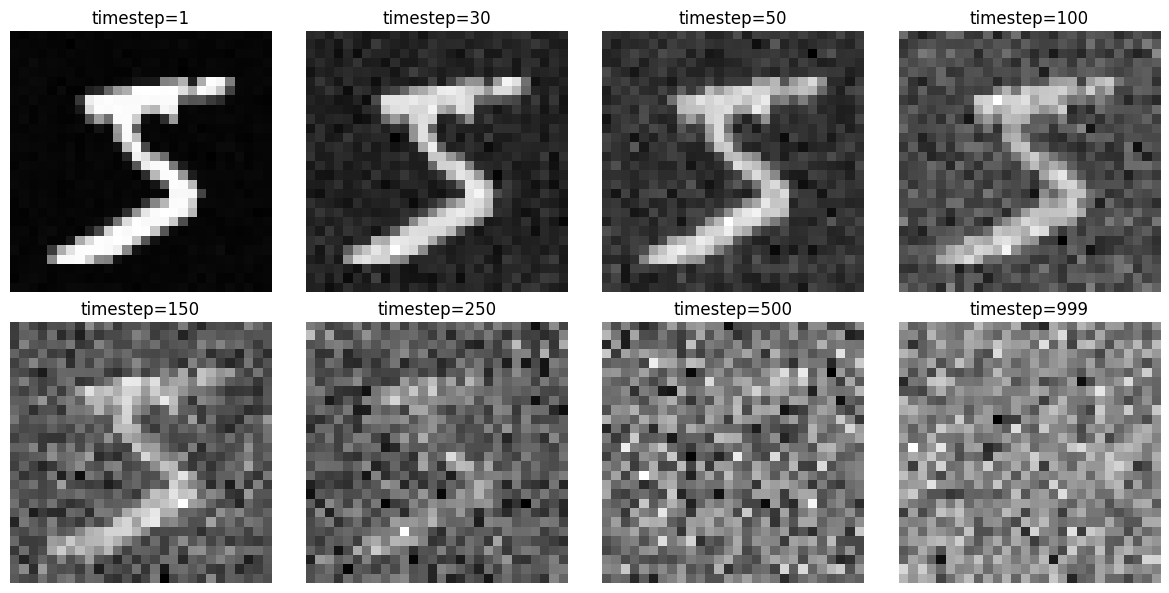

In [27]:
T = 1000
forward_diffusion = ForwardDiffusion(get_beta_schedule(T))

timesteps_to_plot = [1, 30, 50, 100, 150, 250, 500, 999]

image = next(iter(mnist_loader))["x"][:1, 0]

# ====
# ваш код
# по аналогии с тем, как мы делали для SwissRoll,
# примените прямой процесс диффузии к переменной image и
# визуализируйте зашумлённую картинку в разные моменты времени (включая самый последний шаг)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, timestep in enumerate(timesteps_to_plot):
    row = idx // 4
    col = idx % 4
    
    noised_image = forward_diffusion.q_sample(
        x0=image,
        t=th.ones_like(th.tensor([0])) * timestep,
    )
    
    axes[row, col].imshow(noised_image[0], cmap="gray")
    axes[row, col].set_title(f"timestep={timestep}")
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()
# ====

### Обучите диффузионную модель и получите хорошие генерации с помощью неё

In [36]:
T = 1000
# ====
# ваш код
# выберите гиперпараметры
LR = 0.001  # 0.0001 <= LR <= 0.01
N_ITERS = 10000  # N_ITERS >= 5000
DROP_LABEL = 0.2  # 0.1 <= DROP_LABEL <= 0.5
BATCH_SIZE = 256  # 256 <= BATCH_SIZE <=  2048
# ====

model = MyUNet(use_null_cond=True)

ddpm = DDPMWithCFG(betas=get_beta_schedule(T), model=model)
dataloader = get_labeled_data_loader(mnist_to_train_range(X), y, batch_size=BATCH_SIZE, shuffle=True, drop_label=DROP_LABEL)

train_model(
    ddpm=ddpm,
    dataloader=dataloader,
    lr=LR,
    n_iters=N_ITERS,
    device="cuda"
)

Step 500/10000 Loss: 0.1514
Step 1000/10000 Loss: 0.052
Step 1500/10000 Loss: 0.0436
Step 2000/10000 Loss: 0.039
Step 2500/10000 Loss: 0.0363
Step 3000/10000 Loss: 0.0347
Step 3500/10000 Loss: 0.0334
Step 4000/10000 Loss: 0.0325
Step 4500/10000 Loss: 0.0322
Step 5000/10000 Loss: 0.031
Step 5500/10000 Loss: 0.0306
Step 6000/10000 Loss: 0.0303
Step 6500/10000 Loss: 0.0301
Step 7000/10000 Loss: 0.0297
Step 7500/10000 Loss: 0.0292
Step 8000/10000 Loss: 0.0289
Step 8500/10000 Loss: 0.0288
Step 9000/10000 Loss: 0.0288
Step 9500/10000 Loss: 0.0285
Step 10000/10000 Loss: 0.028


100%|██████████| 1000/1000 [00:06<00:00, 163.64it/s]


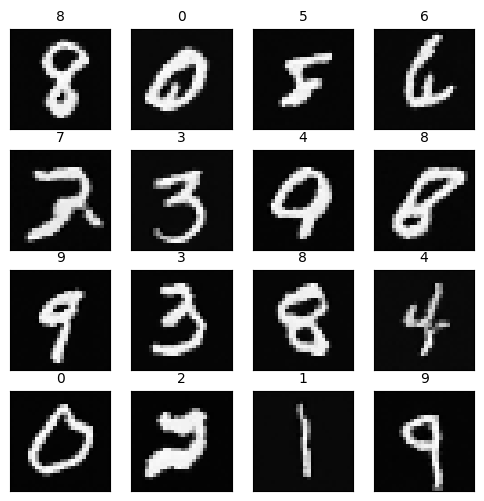

In [38]:
# Теперь давайте посмотрим, что наша модель научилась генерировать

num_samples = 16
ys = th.randint(10, size=(num_samples,), device="cuda")
Xs, ys = ddpm.sample(ys)
show_images(Xs, ys)

### Сравните генерацию с помощью classifier-free с разными guidance scale

Сейчас для генерации в диффузионной модели нам нужно делать 1000 вызовов нейросети.

С classifier-free guidance потребуется 2000 вызовов.

Это долго, и с таким числом шагов сложно быстро экспериментировать.

Поэтому сначала подберём меньшее количество шагов семплирования без classifier-free guidance, при котором качество генерации остаётся хорошим, а затем будем использовать это количество шагов для сравнения разных значений guidance scale.

Используйте: `spaced_ddpm = get_spaced_ddpm(ddpm, ???)`


100%|██████████| 99/99 [00:01<00:00, 85.11it/s]


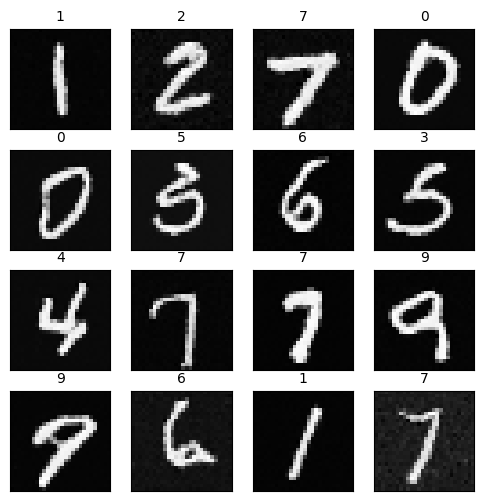

100%|██████████| 249/249 [00:02<00:00, 85.73it/s]


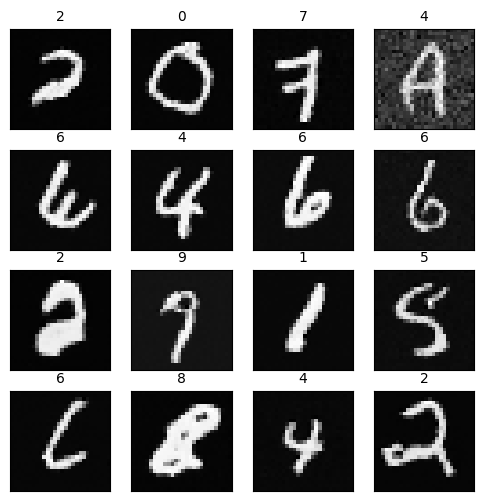

100%|██████████| 499/499 [00:05<00:00, 84.41it/s]


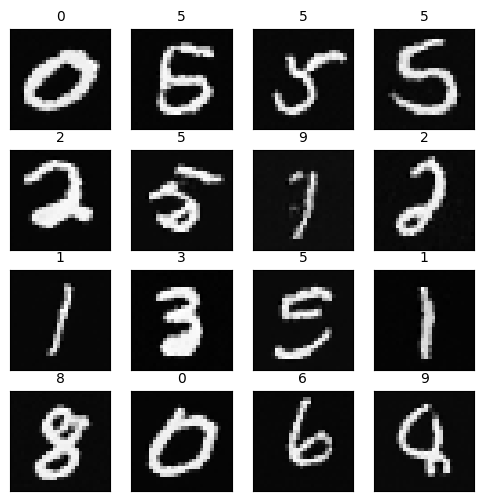

100%|██████████| 749/749 [00:08<00:00, 83.90it/s]


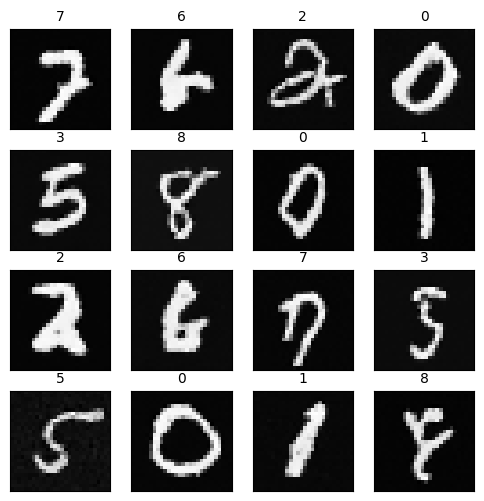

In [39]:
# Попробуем разные значения числа шагов
for n_steps in [100, 250, 500, 750]:
    spaced_ddpm = get_spaced_ddpm(ddpm, n_steps)
    # ====
    # ваш код
    # найдите меньшее число, чем T = 1000, шагов, с которым можно получать хорошие генерации.
    # визуализируйте генерации с этим итоговым числом шагов
    num_samples = 16
    ys = th.randint(10, size=(num_samples,), device="cuda")
    Xs, ys = spaced_ddpm.sample_with_cfg(ys, guidance_scale=1.0, null_label=10)
    show_images(Xs, ys)
    # ====

Остановимся на 500 шагах

100%|██████████| 499/499 [00:05<00:00, 84.15it/s]


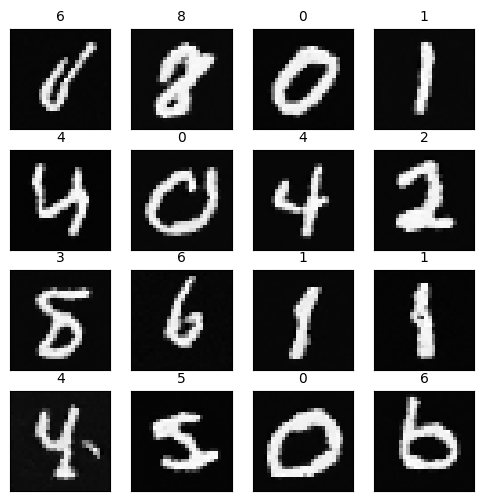

100%|██████████| 499/499 [00:05<00:00, 84.76it/s]


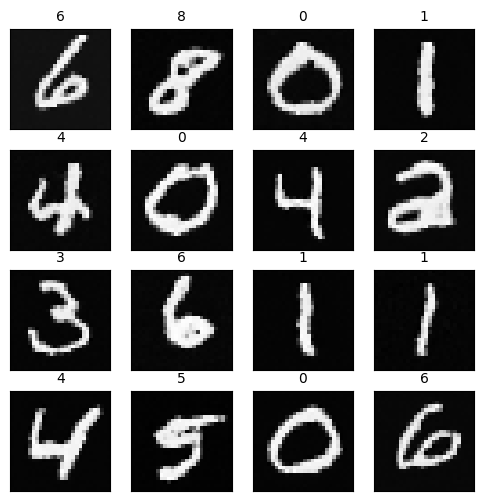

100%|██████████| 499/499 [00:05<00:00, 83.70it/s]


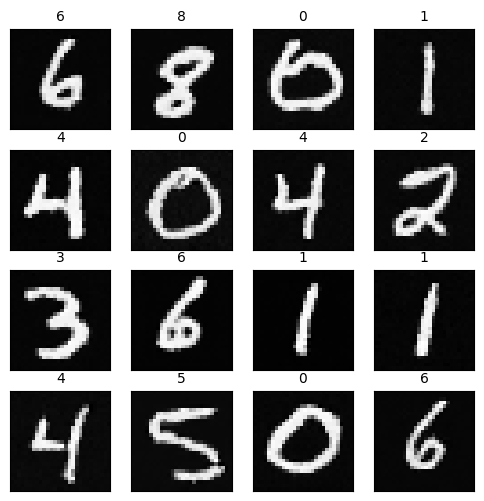

100%|██████████| 499/499 [00:05<00:00, 84.12it/s]


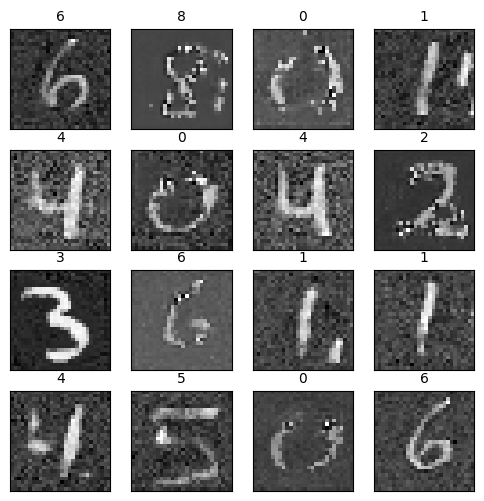

In [40]:
# ====
# ваш код
# визуализируйте генерации, полученные с помощью classifier-free guidance.
# сделайте это и сравните для guidance scale из множества {1, 2, 4, 32}
# (генерации можно визуализировать в разных ячейках)
spaced_ddpm = get_spaced_ddpm(ddpm, 500)

# Guidance scale = 1
num_samples = 16
ys = th.randint(10, size=(num_samples,), device="cuda")
Xs, ys = spaced_ddpm.sample_with_cfg(ys, guidance_scale=1.0, null_label=10)
show_images(Xs, ys)

# Guidance scale = 2
Xs, ys = spaced_ddpm.sample_with_cfg(ys, guidance_scale=2.0, null_label=10)
show_images(Xs, ys)

# Guidance scale = 4
Xs, ys = spaced_ddpm.sample_with_cfg(ys, guidance_scale=4.0, null_label=10)
show_images(Xs, ys)

# Guidance scale = 32
Xs, ys = spaced_ddpm.sample_with_cfg(ys, guidance_scale=32.0, null_label=10)
show_images(Xs, ys)
# ====